In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Load the datasets
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

# Display the first few rows of each dataset
print(customers.head())
print(transactions.head())
print(engagements.head())
print(marketing.head())

# Convert date columns to datetime format
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])

   customer_id   join_date last_purchase_date   age  gender           location
0            1  2023-11-20         2024-03-17  56.0  Female  North Shannonbury
1            2  2021-09-08         2023-10-25   NaN    Male          Hillville
2            3  2021-06-01         2022-11-27   NaN     NaN   North Latoyatown
3            4  2022-01-01         2022-09-01  29.0    Male          Grossstad
4            5  2022-01-24         2023-06-02   NaN    Male   East Matthewfort
   transaction_id  customer_id transaction_date  transaction_amount  \
0               1            1       2024-02-03              165.56   
1               2            1       2024-03-02              699.01   
2               3            1       2024-03-12              146.86   
3               4            1       2024-01-20              927.46   
4               5            1       2024-02-25             1395.87   

  product_category  
0         Clothing  
1       Home Goods  
2       Home Goods  
3      Electron

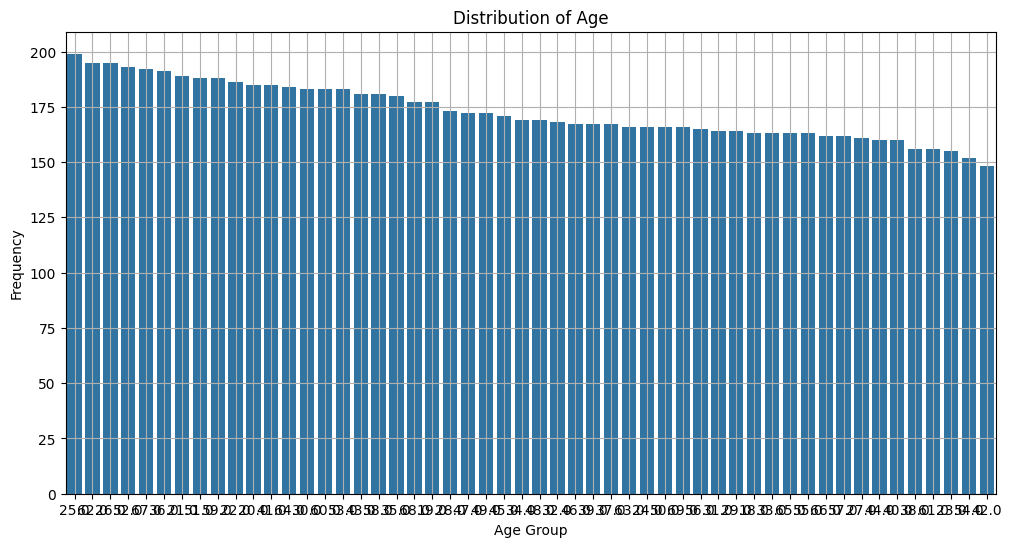

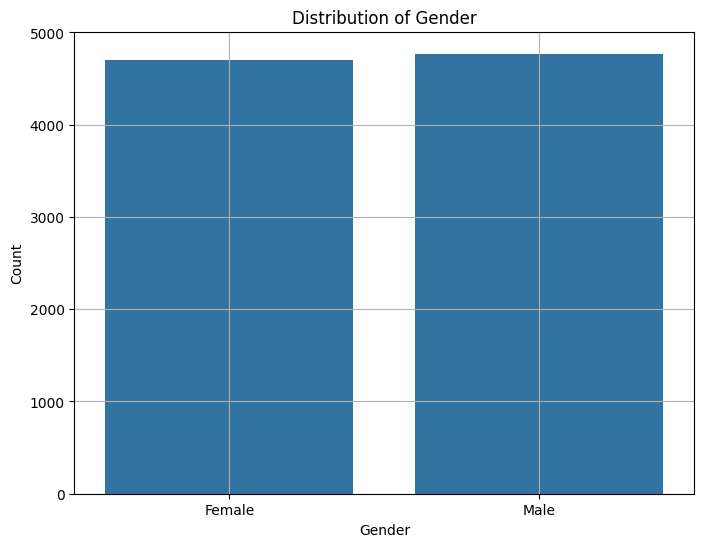

In [61]:
# Plot the distribution of age
plt.figure(figsize=(12, 6))
sns.countplot(x='age', data=customers, order=customers['age'].value_counts().index)
plt.title('Distribution of Age')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=customers)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [62]:
# Find the latest date among all datasets
latest_date_customers = customers[['join_date', 'last_purchase_date']].max().max()
latest_date_transactions = transactions['transaction_date'].max()
latest_date_marketing = marketing['campaign_date'].max()

# Find the overall latest date
overall_latest_date = max(latest_date_customers, latest_date_transactions, latest_date_marketing)
print(f'Latest Date among all data: {overall_latest_date}')

# So 2024-05-31 is the date we stand at

Latest Date among all data: 2024-05-31 00:00:00


In [63]:
# Fill missing values for gender with "Unknown"
customers['gender'].fillna('Unknown', inplace=True)

# Fill missing values in the age column with "Unknown"
customers['age'] = customers['age'].fillna('Unknown')

# Convert age into categorical ranges
bins = [-1, 29, 39, 49, 59, np.inf]
labels = ['0-29', '30-39', '40-49', '50-59', '60+']
customers['age'] = pd.cut(customers['age'].replace('Unknown', -1).astype(float), bins=bins, labels=labels)
customers['age'] = customers['age'].cat.add_categories('Unknown').fillna('Unknown')

# Check if there are any remaining missing values
print(customers.isnull().sum())

customer_id           0
join_date             0
last_purchase_date    0
age                   0
gender                0
location              0
dtype: int64


/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_1562/3142064180.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['gender'].fillna('Unknown', inplace=True)
/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_1562/3142064180.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tr

In [64]:
# Merge datasets on customer_id
data = pd.merge(customers, transactions, on='customer_id', how='left')
data = pd.merge(data, engagements, on='customer_id', how='left')
data = pd.merge(data, marketing, on='customer_id', how='left')

# Display the first few rows of the merged dataset
print(data.head())

   customer_id  join_date last_purchase_date    age  gender  \
0            1 2023-11-20         2024-03-17  50-59  Female   
1            1 2023-11-20         2024-03-17  50-59  Female   
2            1 2023-11-20         2024-03-17  50-59  Female   
3            1 2023-11-20         2024-03-17  50-59  Female   
4            1 2023-11-20         2024-03-17  50-59  Female   

            location  transaction_id transaction_date  transaction_amount  \
0  North Shannonbury               1       2024-02-03              165.56   
1  North Shannonbury               1       2024-02-03              165.56   
2  North Shannonbury               1       2024-02-03              165.56   
3  North Shannonbury               1       2024-02-03              165.56   
4  North Shannonbury               2       2024-03-02              699.01   

  product_category  number_of_site_visits  number_of_emails_opened  \
0         Clothing                     10                       15   
1         Clothing

In [65]:
# Define the date range for the analysis
start_date = '2023-06-01'
end_date = '2024-05-31'
reference_date = pd.to_datetime(end_date)

# Filter transactions within the specified period
filtered_transactions = transactions[(transactions['transaction_date'] >= start_date) & (transactions['transaction_date'] <= end_date)]

# Filter marketing data within the specified period
filtered_marketing = marketing[(marketing['campaign_date'] >= start_date) & (marketing['campaign_date'] <= end_date)]

# Feature Engineering
# Recency: Days since last transaction
last_transaction_date = filtered_transactions.groupby('customer_id')['transaction_date'].max().reset_index()
last_transaction_date.columns = ['customer_id', 'last_transaction_date']
customers = pd.merge(customers, last_transaction_date, on='customer_id', how='left')
customers['recency'] = (reference_date - customers['last_purchase_date']).dt.days
customers['recency'].fillna((reference_date - customers['join_date']).dt.days, inplace=True)  # Fill NaN with join_date if no transaction

# Frequency: Number of transactions within the year
transaction_frequency = filtered_transactions.groupby('customer_id').size().reset_index(name='frequency')
customers = pd.merge(customers, transaction_frequency, on='customer_id', how='left')
customers['frequency'].fillna(0, inplace=True)

# Lifespan: Days from join date to reference date
customers['lifespan'] = (reference_date - customers['join_date']).dt.days

# Positive Response: Number of 'Yes' responses within the year
positive_responses = filtered_marketing[filtered_marketing['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='positive_response')
customers = pd.merge(customers, positive_responses, on='customer_id', how='left')
customers['positive_response'].fillna(0, inplace=True)

# Transaction Diversity: Number of different product categories purchased within the year
transaction_diversity = filtered_transactions.groupby('customer_id')['product_category'].nunique().reset_index(name='transaction_diversity')
customers = pd.merge(customers, transaction_diversity, on='customer_id', how='left')
customers['transaction_diversity'].fillna(0, inplace=True)

# Transaction Standard Deviation: Standard deviation of transaction amounts within the year
transaction_std = filtered_transactions.groupby('customer_id')['transaction_amount'].std().reset_index(name='transaction_standard_deviation')
customers = pd.merge(customers, transaction_std, on='customer_id', how='left')
customers['transaction_standard_deviation'].fillna(0, inplace=True)

# Calculate total transactions per customer for proportion
total_transactions = transactions.groupby('customer_id').size().reset_index(name='total_transactions')
customers = pd.merge(customers, total_transactions, on='customer_id', how='left')
customers['total_transactions'].fillna(0, inplace=True)

# Calculate engagement frequency
customers['engagement_frequency'] = np.where(customers['total_transactions'] == 0, 0, customers['frequency'] / customers['total_transactions'])
customers['engagement_frequency'].replace([np.inf, -np.inf], 0, inplace=True)  # Handle division by zero

# Merge engagement data and calculate engagement metrics
customers = pd.merge(customers, engagements, on='customer_id', how='left')
customers['site_visit'] = customers['number_of_site_visits'] * customers['engagement_frequency']
customers['email_per_transaction'] = customers['number_of_emails_opened'] * customers['engagement_frequency']
customers['click_per_transaction'] = customers['number_of_clicks'] * customers['engagement_frequency']

# Fill NaN values in engagement features
customers[['site_visit', 'email_per_transaction', 'click_per_transaction']] = customers[['site_visit', 'email_per_transaction', 'click_per_transaction']].fillna(0)

# Create age-gender interaction term
customers['age_gender'] = customers['age'].astype(str) + '_' + customers['gender'].astype(str)

# Filter out customers who joined after 2023-06-01
modeling_data = customers[customers['join_date'] < pd.to_datetime(start_date)]

# Select the important features for modeling
modeling_features = ['customer_id', 'age_gender', 'recency', 'frequency', 'lifespan', 'positive_response', 'transaction_diversity', 'transaction_standard_deviation', 'site_visit', 'email_per_transaction', 'click_per_transaction']

# Print the prepared columns
print(modeling_data[modeling_features].head())

   customer_id       age_gender  recency  frequency  lifespan  \
1            2     Unknown_Male      219        0.0       996   
2            3  Unknown_Unknown      551        0.0      1095   
3            4        0-29_Male      638        0.0       881   
4            5     Unknown_Male      364        1.0       858   
5            6     50-59_Female      476        0.0       881   

   positive_response  transaction_diversity  transaction_standard_deviation  \
1                0.0                    0.0                             0.0   
2                0.0                    0.0                             0.0   
3                0.0                    0.0                             0.0   
4                0.0                    1.0                             0.0   
5                0.0                    0.0                             0.0   

   site_visit  email_per_transaction  click_per_transaction  
1    0.000000               0.000000               0.000000  
2    0.000

/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_1562/2318496441.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customers['recency'].fillna((reference_date - customers['join_date']).dt.days, inplace=True)  # Fill NaN with join_date if no transaction
/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_1562/2318496441.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace m

In [66]:
modeling_data.describe()

,customer_id,join_date,last_purchase_date,last_transaction_date,recency,frequency,lifespan,positive_response,transaction_diversity,transaction_standard_deviation,total_transactions,engagement_frequency,number_of_site_visits,number_of_emails_opened,number_of_clicks,site_visit,email_per_transaction,click_per_transaction
count,7711.000000,7711,7711,2764,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000,7711.00000,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000,7711.000000
mean,4994.560887,2021-09-16 01:14:41.908961024,2023-01-23 20:06:34.034496,2023-10-31 17:29:46.975397888,493.162106,1.967319,987.948126,0.195824,0.791078,128.046823,12.91363,0.152963,123.210738,49.003501,24.260796,19.254116,7.653134,3.768421
min,2.000000,2020-01-01 00:00:00,2020-01-26 00:00:00,2023-06-01 00:00:00,0.000000,0.000000,366.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2494.500000,2020-11-06 00:00:00,2022-06-12 00:00:00,2023-08-12 00:00:00,213.000000,0.000000,673.000000,0.000000,0.000000,0.000000,7.00000,0.000000,29.000000,12.000000,6.000000,0.000000,0.000000,0.000000
50%,4992.000000,2021-09-19 00:00:00,2023-04-01 00:00:00,2023-10-24 00:00:00,426.000000,0.000000,985.000000,0.000000,0.000000,0.000000,13.00000,0.000000,82.000000,33.000000,16.000000,0.000000,0.000000,0.000000
75%,7493.000000,2022-07-28 00:00:00,2023-10-31 00:00:00,2024-01-13 00:00:00,719.000000,2.000000,1302.000000,0.000000,2.000000,191.391297,19.00000,0.230769,175.000000,72.000000,35.000000,19.182540,8.000000,3.902381
max,10000.000000,2023-05-31 00:00:00,2024-05-31 00:00:00,2024-05-28 00:00:00,1587.000000,25.000000,1612.000000,4.000000,3.000000,1285.315067,25.00000,1.000000,711.000000,303.000000,142.000000,587.000000,194.000000,113.000000
std,2886.059403,NaN,NaN,NaN,349.606191,3.836134,360.620526,0.523669,1.167348,232.062339,7.20254,0.263174,125.345715,49.058234,24.236670,41.253103,15.909846,7.887238


/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_1562/1802771794.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  modeling_data['CLV_latest_year'].fillna(0, inplace=True)


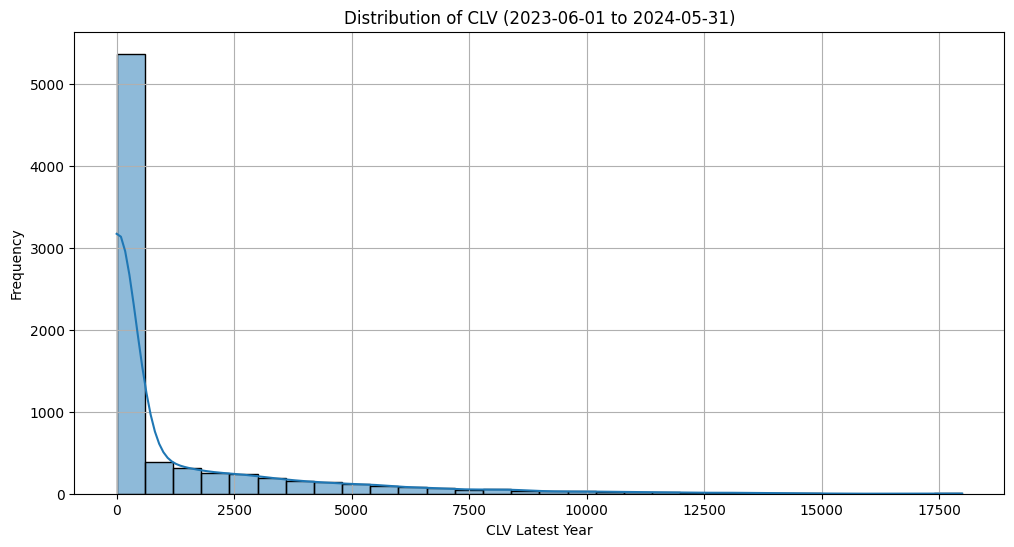

In [67]:
# Calculate CLV for the latest year (2023-06-01 to 2024-05-31)
clv_latest_year = filtered_transactions.groupby('customer_id')['transaction_amount'].sum().reset_index()
clv_latest_year.columns = ['customer_id', 'CLV_latest_year']

# Merge the CLV data with modeling_data
modeling_data = pd.merge(modeling_data, clv_latest_year, on='customer_id', how='left')
modeling_data['CLV_latest_year'].fillna(0, inplace=True)

# Plot the distribution of CLV_latest_year
plt.figure(figsize=(12, 6))
sns.histplot(modeling_data['CLV_latest_year'], bins=30, kde=True)
plt.title('Distribution of CLV (2023-06-01 to 2024-05-31)')
plt.xlabel('CLV Latest Year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [68]:
modeling_data['CLV_latest_year'].describe()

count     7711.000000
mean      1177.900691
std       2389.191388
min          0.000000
25%          0.000000
50%          0.000000
75%       1252.540000
max      17989.680000
Name: CLV_latest_year, dtype: float64

In [69]:
# Calculate the threshold for the top 25% of customers
threshold1 = modeling_data['CLV_latest_year'].quantile(0.75)

# Assign labels based on the threshold
modeling_data['highvalue_customer'] = (modeling_data['CLV_latest_year'] >= threshold1).astype(int)

# Verify the labeling
print(modeling_data[['customer_id', 'CLV_latest_year', 'highvalue_customer']].head())

# Ensure the top 25% threshold is correctly applied
print(f'Threshold for top 25% customers: {threshold1}')
print(modeling_data['highvalue_customer'].value_counts())


   customer_id  CLV_latest_year  highvalue_customer
0            2             0.00                   0
1            3             0.00                   0
2            4             0.00                   0
3            5            43.88                   0
4            6             0.00                   0
Threshold for top 25% customers: 1252.54
highvalue_customer
0    5783
1    1928
Name: count, dtype: int64


In [70]:
modeling_data


,customer_id,join_date,last_purchase_date,age,gender,location,last_transaction_date,recency,frequency,lifespan,...,engagement_frequency,number_of_site_visits,number_of_emails_opened,number_of_clicks,site_visit,email_per_transaction,click_per_transaction,age_gender,CLV_latest_year,highvalue_customer
0,2,2021-09-08,2023-10-25,Unknown,Male,Hillville,NaT,219,0.0,996,...,0.000000,285,49,51,0.000000,0.000000,0.000000,Unknown_Male,0.00,0
1,3,2021-06-01,2022-11-27,Unknown,Unknown,North Latoyatown,NaT,551,0.0,1095,...,0.000000,192,73,25,0.000000,0.000000,0.000000,Unknown_Unknown,0.00,0
2,4,2022-01-01,2022-09-01,0-29,Male,Grossstad,NaT,638,0.0,881,...,0.000000,110,30,17,0.000000,0.000000,0.000000,0-29_Male,0.00,0
3,5,2022-01-24,2023-06-02,Unknown,Male,East Matthewfort,2023-06-01,364,1.0,858,...,0.041667,161,2,7,6.708333,0.083333,0.291667,Unknown_Male,43.88,0
4,6,2022-01-01,2023-02-10,50-59,Female,North Richardfort,NaT,476,0.0,881,...,0.000000,74,59,7,0.000000,0.000000,0.000000,50-59_Female,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7706,9995,2020-08-06,2022-04-10,Unknown,Male,Port Jermaine,NaT,782,0.0,1394,...,0.000000,66,115,19,0.000000,0.000000,0.000000,Unknown_Male,0.00,0
7707,9996,2022-12-16,2023-08-13,40-49,Female,Johnstonborough,2023-06-11,292,3.0,532,...,0.300000,119,47,16,35.700000,14.100000,4.800000,40-49_Female,1096.25,0
7708,9997,2022-07-09,2023-01-25,0-29,Male,Jessicamouth,NaT,492,0.0,692,...,0.000000,3,33,14,0.000000,0.000000,0.000000,0-29_Male,0.00,0
7709,9999,2022-05-10,2022-07-15,30-39,Female,Andrewland,NaT,686,0.0,752,...,0.000000,23,5,4,0.000000,0.000000,0.000000,30-39_Female,0.00,0


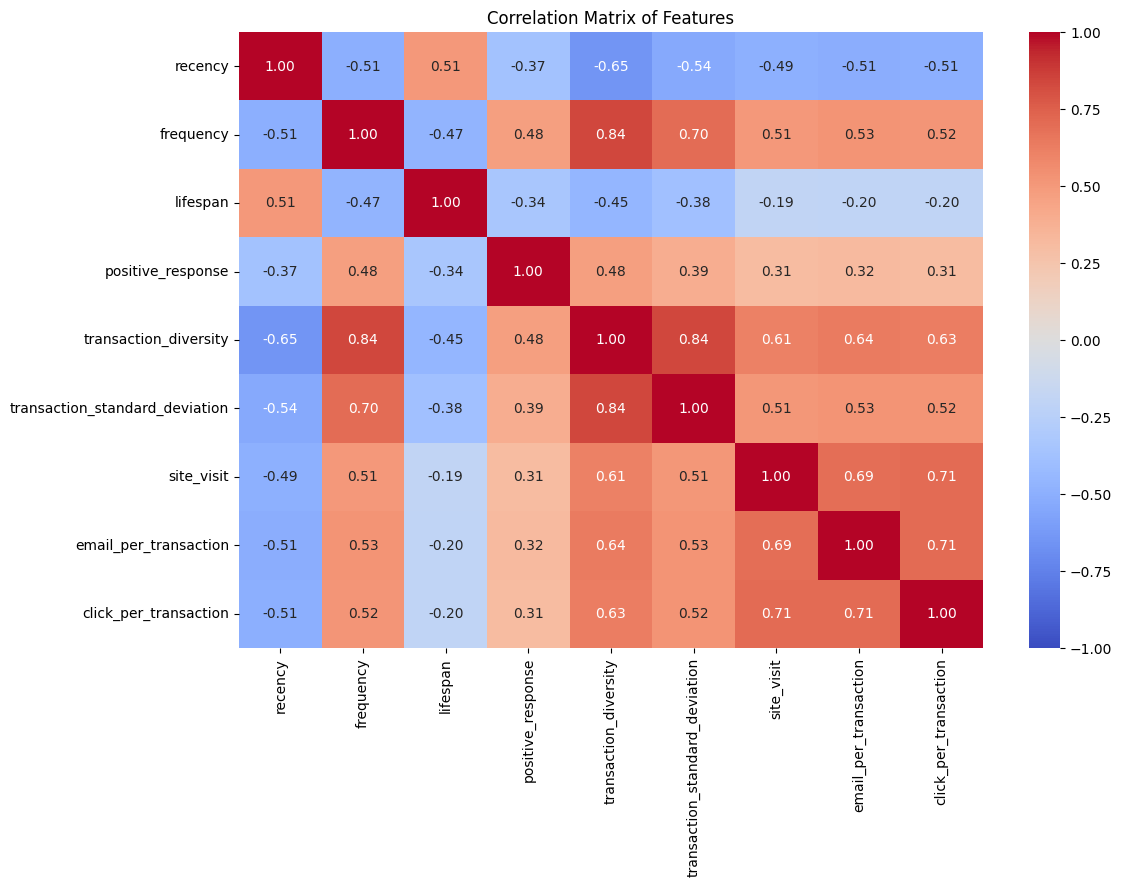

In [71]:
# Independent variables
independent_features = ['recency', 'frequency', 'lifespan', 'positive_response', 'transaction_diversity', 'transaction_standard_deviation', 'site_visit', 'email_per_transaction', 'click_per_transaction']

# Create the correlation matrix
correlation_matrix = modeling_data[independent_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()

In [72]:
# Independent variables
independent_features = ['recency', 'frequency', 'lifespan', 'positive_response', 'transaction_diversity', 'transaction_standard_deviation', 'site_visit', 'email_per_transaction', 'click_per_transaction', 'age_gender']

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), independent_features[:-1]),  # All columns except 'age_gender'
        ('cat', OneHotEncoder(), ['age_gender'])
    ]
)

# Apply the transformations
X = preprocessor.fit_transform(modeling_data[independent_features])

# Convert the result back to a DataFrame for ease of use
feature_names = independent_features[:-1] + list(preprocessor.named_transformers_['cat'].get_feature_names_out(['age_gender']))
X_df = pd.DataFrame(X, columns=feature_names)

# Print the transformed features
print(X_df.head())

    recency  frequency  lifespan  positive_response  transaction_diversity  \
0  0.137996       0.00  0.505618                0.0               0.000000   
1  0.347196       0.00  0.585072                0.0               0.000000   
2  0.402016       0.00  0.413323                0.0               0.000000   
3  0.229364       0.04  0.394864                0.0               0.333333   
4  0.299937       0.00  0.413323                0.0               0.000000   

   transaction_standard_deviation  site_visit  email_per_transaction  \
0                             0.0    0.000000                0.00000   
1                             0.0    0.000000                0.00000   
2                             0.0    0.000000                0.00000   
3                             0.0    0.011428                0.00043   
4                             0.0    0.000000                0.00000   

   click_per_transaction  age_gender_0-29_Female  ...  \
0               0.000000                 

In [80]:
# Prepare the target variable
y = modeling_data['highvalue_customer']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.3, random_state=42)

# Initialize the models
logreg = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier()

# Train and evaluate Logistic Regression
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

logreg_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_logreg),
    'Precision': precision_score(y_test, y_pred_logreg),
    'Recall': recall_score(y_test, y_pred_logreg),
    'F1 Score': f1_score(y_test, y_pred_logreg)
}

print("Logistic Regression Metrics:")
for metric, value in logreg_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nLogistic Regression Coefficients:")
logreg_coefficients = pd.DataFrame(logreg.coef_.flatten(), index=feature_names, columns=['Coefficient'])
print(logreg_coefficients)

# Train and evaluate Naive Bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

nb_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'Precision': precision_score(y_test, y_pred_nb),
    'Recall': recall_score(y_test, y_pred_nb),
    'F1 Score': f1_score(y_test, y_pred_nb)
}

print("\nNaive Bayes Metrics:")
for metric, value in nb_metrics.items():
    print(f"{metric}: {value:.4f}")

# Train and evaluate KNN
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

knn_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn),
    'F1 Score': f1_score(y_test, y_pred_knn)
}

print("\nK-Nearest Neighbors Metrics:")
for metric, value in knn_metrics.items():
    print(f"{metric}: {value:.4f}")

# Note: KNN and Naive Bayes don't provide coefficients in the same way Logistic Regression does.

Logistic Regression Metrics:
Accuracy: 0.9602
Precision: 0.9190
Recall: 0.9190
F1 Score: 0.9190

Logistic Regression Coefficients:
                                Coefficient
recency                           -2.959331
frequency                          6.701909
lifespan                          -0.784651
positive_response                  0.472741
transaction_diversity              3.412302
transaction_standard_deviation     6.530400
site_visit                         0.481404
email_per_transaction              1.133072
click_per_transaction              0.728420
age_gender_0-29_Female             0.267052
age_gender_0-29_Male               0.265072
age_gender_0-29_Unknown           -0.080009
age_gender_30-39_Female           -0.054703
age_gender_30-39_Male             -0.053123
age_gender_30-39_Unknown          -0.000124
age_gender_40-49_Female           -0.131150
age_gender_40-49_Male             -0.007733
age_gender_40-49_Unknown           0.307434
age_gender_50-59_Female          

In [81]:
X_train

,recency,frequency,lifespan,positive_response,transaction_diversity,transaction_standard_deviation,site_visit,email_per_transaction,click_per_transaction,age_gender_0-29_Female,...,age_gender_40-49_Unknown,age_gender_50-59_Female,age_gender_50-59_Male,age_gender_50-59_Unknown,age_gender_60+_Female,age_gender_60+_Male,age_gender_60+_Unknown,age_gender_Unknown_Female,age_gender_Unknown_Male,age_gender_Unknown_Unknown
3094,0.018904,0.28,0.278491,0.25,1.000000,0.174334,0.159796,0.125086,0.235398,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2117,0.267171,0.00,0.891653,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,0.477631,0.00,0.849117,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5856,0.640832,0.00,0.555377,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4414,0.056081,0.08,0.226324,0.00,0.666667,0.537418,0.018171,0.068729,0.159292,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.850662,0.00,0.864366,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5390,0.557026,0.00,0.496790,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
860,0.470699,0.00,0.961477,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7603,0.144297,0.12,0.243178,0.00,0.666667,0.614751,0.029898,0.057990,0.051770,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Define the hyperparameters for each model
param_grid = [
    {'classifier__penalty': ['l1', 'l2'],
     'classifier__C': [0.01, 0.1, 1, 10, 100],
     'classifier__solver': ['liblinear']},

    {'classifier__penalty': ['l2'],
     'classifier__C': [0.01, 0.1, 1, 10, 100],
     'classifier__solver': ['lbfgs', 'sag']},

    {'classifier__penalty': ['elasticnet'],
     'classifier__C': [0.01, 0.1, 1, 10, 100],
     'classifier__solver': ['saga'],
     'classifier__l1_ratio': [0.5, 0.7, 0.9]},

    {'classifier__penalty': [None],
     'classifier__C': [0.01, 0.1, 1, 10, 100],
     'classifier__solver': ['lbfgs']}
]

nb_param_grid = {
    'classifier__var_smoothing': np.logspace(0, -9, num=100)
}

knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform GridSearchCV for Logistic Regression
logreg_grid_search = GridSearchCV(logreg, logreg_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
logreg_grid_search.fit(X_train, y_train)

# Perform GridSearchCV for Naive Bayes
nb_grid_search = GridSearchCV(nb, nb_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
nb_grid_search.fit(X_train, y_train)

# Perform GridSearchCV for KNN
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
knn_grid_search.fit(X_train, y_train)

# Print the best parameters and best scores for each model
print("Best Parameters for Logistic Regression:")
print(logreg_grid_search.best_params_)
print("Best F1 Score for Logistic Regression:")
print(logreg_grid_search.best_score_)

print("\nBest Parameters for Naive Bayes:")
print(nb_grid_search.best_params_)
print("Best F1 Score for Naive Bayes:")
print(nb_grid_search.best_score_)

print("\nBest Parameters for KNN:")
print(knn_grid_search.best_params_)
print("Best F1 Score for KNN:")
print(knn_grid_search.best_score_)


Fitting 5 folds for each of 80 candidates, totalling 400 fits


ValueError: Invalid parameter 'classifier' for estimator LogisticRegression(). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].